# Setup

In [14]:
import time
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class ArgumentParser:
    def add_argument(self, str, type, default):
        setattr(self, str[2:], default)

    def parse_args(self):
        return self

parser = ArgumentParser()
parser.add_argument('--tol', type=float, default=1e-7)
parser.add_argument('--adjoint', type=eval, default=False)
parser.add_argument('--visualise', type=eval, default=True)
parser.add_argument('--niters', type=int, default=300)
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--data_dimension', type=int, default=2)
parser.add_argument('--npoints', type=int, default=50)
parser.add_argument('--ntest', type=int, default=10)
args = parser.parse_args()

! pip install torchdiffeq
from torchdiffeq import odeint_adjoint as odeint


In [2]:
from google.colab import drive
drive.mount('/content/drive')
! cp -r drive/MyDrive/nested-n-spheres/data ./data.

Mounted at /content/drive


In [3]:
import csv
class Recorder:
    def __init__(self):
        self.store = []
        self.current = dict()

    def __setitem__(self, key, value):
        for method in ['detach', 'cpu', 'numpy', 'flatten']:
            if hasattr(value, method):
                value = getattr(value, method)()
        if key in self.current:
            self.current[key].append(value)
        else:
            self.current[key] = [value]

    def capture(self, verbose=False):
        for i in self.current:
            self.current[i] = np.mean(self.current[i])
        self.store.append(self.current.copy())
        self.current = dict()
        if verbose:
            for i in self.store[-1]:
                print('{}: {}'.format(i, self.store[-1][i]))
        return self.store[-1]

    def tolist(self):
        labels = set()
        labels = sorted(labels.union(*self.store))
        outlist = []
        for obs in self.store:
            outlist.append([obs.get(i, np.nan) for i in labels])
        return labels, outlist

    def writecsv(self, writer):
        
        labels, outlist = self.tolist()
        if isinstance(writer, str):
            outfile = open(writer, 'w')
            csvwriter = csv.writer(outfile)
            csvwriter.writerow(labels)
            csvwriter.writerows(outlist)
            outfile.close()
        else:
            csvwriter = writer
            csvwriter.writerow(labels)
            csvwriter.writerows(outlist)

# Model

In [4]:
totallist = []

In [5]:
modelname = 'GHBNODE'
seed = 100
res = 0.0
if modelname == 'GHBNODE':
    res = 2

def tanhc(x):
    a = 20
    return x#a * torch.tanh(x / a)

class initial_velocity(nn.Module):
    
    def __init__(self, dim, nhidden):
        super(initial_velocity, self).__init__()
        self.tanh = nn.Hardtanh(min_val=-5.0, max_val=5.0, inplace=False)
        self.fc1 = nn.Linear(dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, dim)
        
    def forward(self, x0):
        out = self.fc1(x0)
        out = self.tanh(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.fc3(out)
        return torch.cat((x0, out))


class ODEfunc(nn.Module):

    def __init__(self, dim, nhidden):
        super(ODEfunc, self).__init__()
        indim = 2 * dim if modelname == 'SONODE' else dim
        self.elu = nn.ELU(inplace=False)
        self.fc1 = nn.Linear(indim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, dim)
        self.gamma = nn.Parameter(torch.Tensor([-3.0]))
        self.nfe = 0
        self.actv = tanhc

    def forward(self, t, x):
        cutoff = int(len(x)/2)
        z = x[:cutoff]
        v = x[cutoff:]
        self.nfe += 1
        if modelname == 'SONODE':
            z = torch.cat((z, v), dim=1)
        out = self.fc1(z)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        if modelname == 'SONODE':
            out = self.fc3(out)
            return torch.cat((v, out))
        else:
            out = self.fc3(out) - torch.sigmoid(self.gamma) * v + res * z
            return torch.cat((self.actv(-v), out))
    

class ODEBlock(nn.Module):

    def __init__(self, odefunc, t0_, tN_):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_times = torch.tensor([t0_, tN_]).float()
        
    def forward(self, x):
        out = odeint(self.odefunc, x, self.integration_times, rtol=args.tol, atol=args.tol)
        out = out[1][:int(len(x)/2)]
        return out

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value
        
        
class Decoder(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(Decoder, self).__init__()
        self.tanh = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
        self.fc = nn.Linear(in_dim, out_dim)

    def forward(self, z):
        out = self.fc(z)
        out = self.tanh(out)
        return out


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
def train():
    device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
    filename = 'hbnode./'
    try:
        os.makedirs('./'+filename)
    except FileExistsError:
        pass
        
    rec = Recorder()
    dim = args.data_dimension
    outputarr = []

    #Download Data
    name_in = str(args.data_dimension)+'din_'+str(args.npoints)+'_train.npy'
    name_out = str(args.data_dimension)+'dout_'+str(args.npoints)+'_train.npy'
    folder_name = 'data./'
    z0 = torch.tensor(np.load(folder_name+name_in)).float().to(device)
    zN = torch.tensor(np.load(folder_name+name_out)).float().to(device)
    viz_z0 = torch.tensor(np.load('data./vis_data/2d_vis_data.npy')).float().to(device)


    # model
    t0, tN = 0, 1
    nhidden = 14
    feature_layers = [initial_velocity(dim, nhidden), ODEBlock(ODEfunc(dim, nhidden), t0, tN), Decoder(dim, 1)]
    model = nn.Sequential(*feature_layers).to(device)
    print(f'Model Parameters = {count_parameters(model)}')
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    loss_func = nn.MSELoss()
    
    itr_arr = np.empty(args.niters)
    loss_arr = np.empty(args.niters)
    nfe_arr = np.empty(args.niters)
    time_arr = np.empty(args.niters)

    # training
    start_time = time.time()
    for itr in range(1, args.niters + 1):
        rec['epoch'] = itr
        feature_layers[1].nfe = 0
        iter_start_time = time.time()
        optimizer.zero_grad()

        # forward in time and solve ode
        pred_out = model[1](model[0](z0))
        pred_z = model[2](pred_out)
        
        # compute loss
        loss = loss_func(pred_z, zN)
        rec['forward_nfe'] = feature_layers[1].nfe
        loss.backward()
        optimizer.step()
        iter_end_time = time.time()

        #make arrays
        itr_arr[itr-1] = itr
        loss_arr[itr-1] = loss
        nfe_arr[itr-1] = feature_layers[1].nfe
        time_arr[itr-1] = iter_end_time-iter_start_time
        rec['epoch_nfe'] = feature_layers[1].nfe
        rec['loss'] = loss
        rec['log_loss'] = torch.log10(loss)
        rec.capture(verbose=False)
        
        if itr % 100 == 0:
            print('Iter: {}, running MSE: {:.4f}'.format(itr, loss))
            # if loss > 0.2:
            #     raise StopIteration

        feature_layers[1].nfe = 0
        pred_out = model[1](model[0](viz_z0))
        outputarr.append(pred_out.detach())
        

    end_time = time.time()
    # print('\n')
    # print('Training complete after {} iters.'.format(itr))
    # print('Time = ' + str(end_time-start_time))
    loss = loss_func(pred_z, zN).detach().numpy()
    # print('Train MSE = ' +str(loss))
    # print('NFE = ' +str(feature_layers[1].nfe))
    # print('Parameters = '+str(count_parameters(model)))
    # print()
    
    np.save(filename+'itr_arr.npy', itr_arr)
    np.save(filename+'nfe_arr.npy', nfe_arr)
    np.save(filename+'loss_arr.npy', loss_arr)
    np.save(filename+'time_arr.npy', time_arr)
    torch.save(model, filename+'model.pth')
    
           
    # make test data
    name_in = str(args.data_dimension)+'din_'+str(args.ntest)+'_test.npy'
    name_out = str(args.data_dimension)+'dout_'+str(args.ntest)+'_test.npy'
    folder_name = 'data./'
    z0 = torch.tensor(np.load(folder_name+name_in)).float().to(device)
    zN = torch.tensor(np.load(folder_name+name_out)).float().to(device)
    feature_layers[1].nfe = 0
    # Run test data through network
    pred_z = model(z0).to(device)

    # compute loss
    loss = loss_func(pred_z, zN).detach().numpy()
    print('Test MSE = ' +str(loss))
        
    
    if args.visualise:
        try:
            os.makedirs('./figure_data./')
        except FileExistsError:
            pass
        samp_ts = torch.linspace(t0, tN, 30)
        if args.data_dimension == 1:
            z0 = torch.tensor(np.load('data./vis_data/1d_vis_data.npy')).float().to(device)
            y0 = feature_layers[0](z0)
            pred_z = odeint(feature_layers[1].odefunc, y0, samp_ts)
            pred_z = pred_z.detach().numpy()
            np.save('figure_data./hbnode_film_1d', pred_z)
        elif args.data_dimension == 2:
            z0 = torch.tensor(np.load('data./vis_data/2d_vis_data.npy')).float().to(device)
            y0 = feature_layers[0](z0)
            pred_z = odeint(feature_layers[1].odefunc, y0, samp_ts)
            print(pred_z.shape)
            pred_z = pred_z.detach().numpy()
            np.save('figure_data./hbnode_film_2d', pred_z)
        elif args.data_dimension == 3:
            z0 = torch.tensor(np.load('data./vis_data/3d_vis_data.npy')).float().to(device)
            y0 = feature_layers[0](z0)
            pred_z = odeint(feature_layers[1].odefunc, y0, samp_ts)
            pred_z = pred_z.detach().numpy()
            np.save('figure_data./hbnode_film_3d', pred_z)
        else:
            pass

    return rec, outputarr, pred_z

In [ ]:
rec_list = [train()[0] for t in range(100)]

Model Parameters = 568
Iter: 100, running MSE: 0.0008
Iter: 200, running MSE: 0.0000
Iter: 300, running MSE: 0.0000
Test MSE = 0.0
torch.Size([30, 240, 2])
Model Parameters = 568
Iter: 100, running MSE: 0.0000
Iter: 200, running MSE: 0.0000
Iter: 300, running MSE: 0.0000
Test MSE = 0.0
torch.Size([30, 240, 2])
Model Parameters = 568
Iter: 100, running MSE: 0.3065
Iter: 200, running MSE: 0.0051
Iter: 300, running MSE: 0.0000
Test MSE = 0.0
torch.Size([30, 240, 2])
Model Parameters = 568
Iter: 100, running MSE: 0.0000
Iter: 200, running MSE: 0.0000
Iter: 300, running MSE: 0.0000
Test MSE = 0.0
torch.Size([30, 240, 2])
Model Parameters = 568
Iter: 100, running MSE: 0.1030
Iter: 200, running MSE: 0.0000
Iter: 300, running MSE: 0.0000
Test MSE = 0.061154436
torch.Size([30, 240, 2])
Model Parameters = 568
Iter: 100, running MSE: 0.0008
Iter: 200, running MSE: 0.0000
Iter: 300, running MSE: 0.0000
Test MSE = 0.0
torch.Size([30, 240, 2])
Model Parameters = 568
Iter: 100, running MSE: 0.2755
It

In [7]:
print(len(rec_list))

NameError: ignored

In [ ]:
import scipy.io

def calc_mean(rec_list, col=2):
  m = []
  for rec in rec_list:
    m.append(np.array(rec.tolist()[1])[:, col])
  m = np.array(m)
  scipy.io.savemat(f'{modelname}_fnfe.mat', {'data': m})
  np.save(f'{modelname}_fnfe.npy', m)
  return np.mean(m, axis=0)

In [ ]:
calc_mean(rec_list).shape

In [17]:
rec, outputarr, pred_z = train()
        
rec.writecsv('train_{}.csv'.format(modelname))
np.save('trajectory_{}'.format(modelname), pred_z)
totallist.append(rec.tolist()[1])
print(np.array(totallist).shape)
np.save('train_{}'.format(modelname), np.array(totallist))
outputarr = torch.stack(outputarr, dim=0).numpy()
np.save(f'drive/MyDrive/PointCloud/{modelname}_outputarr.npy', outputarr, allow_pickle=True)

Model Parameters = 568
Iter: 100, running MSE: 0.0000
Iter: 200, running MSE: 0.0000
Iter: 300, running MSE: 0.0000
Test MSE = 0.0
torch.Size([30, 240, 2])
(5, 300, 5)


(300, 120, 2) <class 'numpy.ndarray'>


NameError: ignored

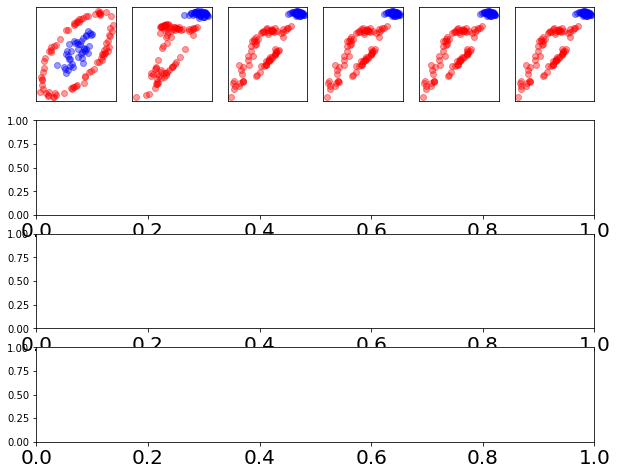

In [18]:
import matplotlib.pyplot as plt
import matplotlib
fsize = 15
plt.rc('axes', labelsize=fsize) #fontsize of the x and y labels
plt.rc('xtick', labelsize=fsize+5) #fontsize of the x tick labels
plt.rc('ytick', labelsize=fsize-5) #fontsize of the y tick labels

print(outputarr.shape, type(outputarr))


ending_time = 300
timespots = np.linspace(0, ending_time, 6, dtype=np.int)
timespots[-1] -= 1
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(4, 6)
axs = [[fig.add_subplot(gs[0, k]) for k in range(6)], [fig.add_subplot(gs[1, :])], [fig.add_subplot(gs[2, :])], [fig.add_subplot(gs[3, :])]]

for j in range(6):
    for i in range(outputarr.shape[1]):
        ts = timespots[j]
        col = 'bo' if i < 40 else 'ro'
        ax = axs[0][j]
        ax.plot(outputarr[ts,i,0], outputarr[ts,i,1], col, alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])

f_nfe = calc_mean(rec_list)[:ending_time]
f_nfeplot = axs[1][0]
f_nfeplot.plot(np.arange(ending_time), f_nfe, linewidth=3)
f_nfeplot.set_ylim([10, 42])
f_nfeplot.set_yticks([10, 20, 30, 40])
f_nfeplot.set_title(f"{modelname}".upper(), fontsize=35)
f_nfeplot.set_ylabel('Forward', fontsize=25)
print(f'Max Forward NFE: {np.max(f_nfe)}')

b_nfe = calc_mean(rec_list, 1)[:ending_time] - f_nfe
b_nfeplot = axs[2][0]
b_nfeplot.plot(np.arange(ending_time), b_nfe, linewidth=3)
b_nfeplot.set_ylim([10, 60])
b_nfeplot.set_yticks([10, 20, 30, 40, 50, 60])
b_nfeplot.set_ylabel('Backward', fontsize=25)
print(f'Max Backward NFE: {np.max(b_nfe)}')

loss = calc_mean(rec_list, col=4)[:ending_time]
lossplot = axs[3][0]
lossplot.plot(np.arange(ending_time), loss, linewidth=3)
lossplot.set_ylabel('Loss', fontsize=25)
lossplot.set_xlabel('Epochs', fontsize=30)
lossplot.set_yticks([0.0, 0.5, 1.0, 1.5])
lossplot.set_ylim([0, 1.5])
print(f'Total NFEs: {np.max(f_nfe) + np.max(b_nfe)}')
print(f'Min Loss: {np.min(loss)}')

plt.tight_layout()
plt.savefig(f'{modelname}_fnfe_pc_plot.pdf', format="pdf", bbox_inches='tight')
plt.show()

In [ ]:
m = np.array(rec_list)

np.save(f'drive/MyDrive/PointCloud/{modelname}_recs_2.npy', m, allow_pickle=True)

# from google.colab import files
# # files.download(f'{modelname}_fnfe.mat') 
# files.download(f'{modelname}_fnfe_pc_plot.pdf')
# files.download(f'{modelname}_recs.npy')

# Plotting

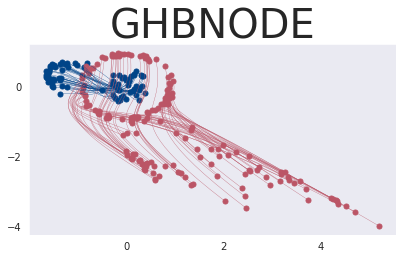

In [ ]:
#! sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng
#! pip install latex


#sonode
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

sns.set_style('dark')


ax3 = plt.plot()

film_data = np.load('figure_data./hbnode_film_2d.npy')

#which frame to stop by
a = len(film_data)

frames = []

for i in range(a):
    frames += [film_data[i][:120]]
    
intermediate = np.asarray(frames)

inner = []
outer = []

for i in range(a):
    inner += [intermediate[i][:40]]
    outer += [intermediate[i][40:]]
    
inner = np.asarray(inner)
outer = np.asarray(outer)


#make film image:

inner_pic = np.empty((40, a, 2))
outer_pic = np.empty((80, a, 2))

for i in range(40):
    for j in range(a):
        inner_pic[i][j] = inner[j][i]
           
for i in range(40):
    inner_pic_plot = np.transpose(inner_pic[i])
    plt.plot(inner_pic_plot[0], inner_pic_plot[1], color='#004488', linewidth=0.3)    
inner_start_frame = np.transpose(inner[0])
inner_end_frame = np.transpose(inner[len(inner)-1])
plt.scatter(inner_start_frame[0], inner_start_frame[1], color='#004488', s=25)
plt.scatter(inner_end_frame[0], inner_end_frame[1], color='#004488', s=25)


for i in range(80):
    for j in range(a):
        outer_pic[i][j] = outer[j][i]
        
for i in range(80):
    outer_pic_plot = np.transpose(outer_pic[i])
    plt.plot(outer_pic_plot[0], outer_pic_plot[1], color='#BB5566', linewidth=0.3)    
outer_start_frame = np.transpose(outer[0])
outer_end_frame = np.transpose(outer[len(inner)-1])
plt.scatter(outer_start_frame[0], outer_start_frame[1], color='#BB5566', s=25)
plt.scatter(outer_end_frame[0], outer_end_frame[1], color='#BB5566', s=25)
#plt.xlabel('x', fontsize=14)
#plt.ylabel('y',fontsize=14)
#plt.xticks([])
#plt.yticks([])
matplotlib.rc('font', size=20)
#rc('text', usetex=True)
plt.title(modelname, fontsize=40)


plt.tight_layout()
#sns.set_style('white')
plt.savefig('nested_n_spheres_{}.pdf'.format(modelname), bbox_inches='tight')
